In [52]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# current data
viirs_url = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/viirs/csv/VNP14IMGTDL_NRT_USA_contiguous_and_Hawaii_24h.csv'
modis_url = 'https://firms.modaps.eosdis.nasa.gov/data/active_fire/c6/csv/MODIS_C6_USA_contiguous_and_Hawaii_24h.csv'

viirs_json = r'/home/nedderlander/datascience/burn notice/Data-Science/Data/Modis_viirs_json/DL_FIRE_V1_72242/fire_archive_V1_72242.json'

## Summary of Data for FIRMS Active Fire

Nasa provides two analysis ready data products that are appropriate for detecting wildfires, MCD14DL that I will refer to as MODIS and VNP14IMGTDL_NRT or VIIRS. 

MODIS is a data product generated from telometry from two satellites Aqua and Terra. It resolves the earth's surface into roughly 1km x 1km pixels and evaluates whether each pixel is on fire using a contextual algorithm that exploits the strong emission of mid-infrared radiation from fires.

VIIRS has a smaller resolution and better global coverage (due to the Suomi-NPP satellite's orbit) and can resolve fire pixels down to 375m. 

Using both data sources should increase data coverage and potentially add a validation element to our model.

In [54]:
import json
data = []


file = open(viirs_json, "r")

limit = 18

for index, line in zip(range(limit), file):
    try:
        line_data = json.dumps(line)
        data.append(line_data)
        print(line_data)
    except Exception as e:
        print(e)
        continue
file.close()


"[\n"
"    {\n"
"        \"latitude\": 39.21748,\n"
"        \"longitude\": -76.47753,\n"
"        \"acq_date\": 2012-01-20,\n"
"        \"acq_time\": 0619,\n"
"        \"frp\": 5.5,\n"
"        \"version\": 1,\n"
"        \"track\": 0.53,\n"
"        \"scan\": 0.59,\n"
"        \"confidence\": n,\n"
"        \"instrument\": VIIRS,\n"
"        \"bright_ti5\": 272.9,\n"
"        \"bright_ti4\": 328.3,\n"
"        \"satellite\": N,\n"
"        \"type\": 2\n"
"    },\n"
"    {\n"


The above cell shows that historical viirs data is missing the daynight feature. This feature is likely important for modis observations so we would like to keep it. This means that we will explore the modis data seperately from viirs.

In [2]:
v = pd.read_csv(viirs_url)
m = pd.read_csv(modis_url)

In [3]:
v.shape, m.shape

((2132, 13), (691, 13))

The hist of latitude between the two current data sources indicate that there may a non-overlapping component to their observations. This suggests that the two data sources may not be suitable for combining into a single dataset.

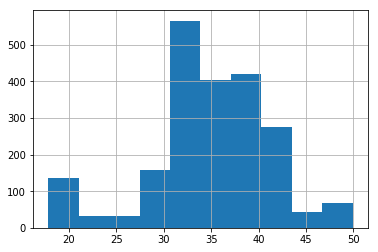

In [50]:
v.latitude.hist()

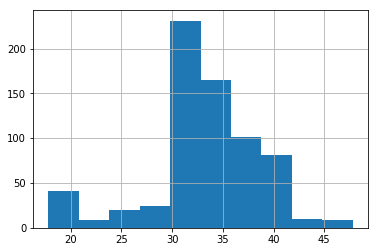

In [51]:
m.latitude.hist()

In [4]:
v.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight
0,46.91339,-64.00330,299.0,0.43,0.38,2019-09-10,600,N,nominal,1.0NRT,280.1,0.7,N
1,46.90993,-64.00423,301.4,0.43,0.38,2019-09-10,600,N,nominal,1.0NRT,280.5,0.7,N
2,46.57857,-80.79469,297.2,0.77,0.77,2019-09-10,600,N,nominal,1.0NRT,277.5,1.2,N
3,20.58317,-76.13242,301.7,0.53,0.50,2019-09-10,612,N,nominal,1.0NRT,276.1,1.4,N
4,19.54364,-70.82060,315.3,0.41,0.37,2019-09-10,612,N,nominal,1.0NRT,286.0,1.7,N


In [5]:
m.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,version,bright_t31,frp,daynight
0,32.130,-93.390,305.0,1.0,1.0,2019-09-10,420,T,62,6.0NRT,285.6,6.7,N
1,32.129,-93.400,325.0,1.0,1.0,2019-09-10,420,T,100,6.0NRT,289.5,23.2,N
2,32.223,-94.056,306.5,1.0,1.0,2019-09-10,420,T,68,6.0NRT,288.4,7.3,N
3,32.222,-94.067,305.8,1.0,1.0,2019-09-10,420,T,66,6.0NRT,289.3,6.7,N
4,37.136,-91.620,312.3,1.1,1.1,2019-09-10,420,T,84,6.0NRT,290.9,11.6,N


These are the current data outputs from modis and viirs, we will match our historical data to the shape of the current datastream.

In [17]:
mv_current = pd.merge(m.drop(columns='confidence'),v.drop(columns='confidence'), how='outer').fillna(0)

# version denotes the sensor product i.e. Modis/virrs, we'll map this to the name for easier recognition
# mapping names onto version
version_to_names = {'6.0NRT' : 'modis', '1.0NRT' : 'viirs'}

mv_current['version'] = mv_current['version'].map(version_to_names)

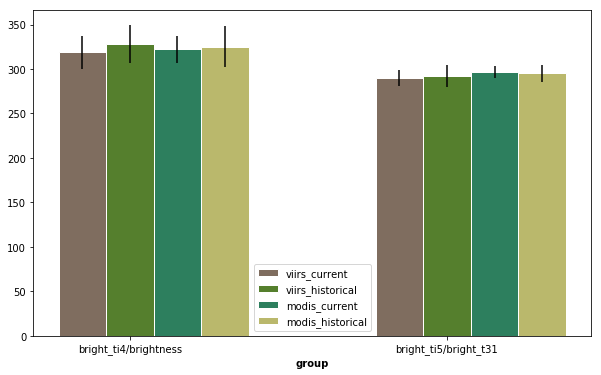

In [24]:
from matplotlib.pyplot import figure
figure(num=1, figsize=(10,6))

# set width of bar
barWidth = 0.15
 
# set height of bar
bars1 = [v.bright_ti4.mean(), v.bright_ti5.mean()]
bars2 = [vh.bright_ti4.mean(), vh.bright_ti5.mean()]
bars3 = [m.brightness.mean(), m.bright_t31.mean()]
bars4 = [mh.brightness.mean(), mh.bright_t31.mean()]

#set error bars
error1 = [v.bright_ti4.std(), v.bright_ti5.std()]
error2 = [vh.bright_ti4.std(), vh.bright_ti5.std()]
error3 = [m.brightness.std(), m.bright_t31.std()]
error4 = [mh.brightness.std(), mh.bright_t31.std()]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, yerr=error1, color='#7f6d5f', width=barWidth, edgecolor='white', label='viirs_current')
plt.bar(r2, bars2, yerr=error2, color='#557f2d', width=barWidth, edgecolor='white', label='viirs_historical')
plt.bar(r3, bars3, yerr=error3, color='#2d7f5e', width=barWidth, edgecolor='white', label='modis_current')
plt.bar(r4, bars4, yerr=error4, color='#bab86c', width=barWidth, edgecolor='white', label='modis_historical')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['bright_ti4/brightness', 'bright_ti5/bright_t31'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

We are comparing the current and historical data to see if values/collection standards are within the same ranges. This result suggests that we can consolidate bright_ti4 and brightness into a single feature as well as bright_ti5 and bright_t31.

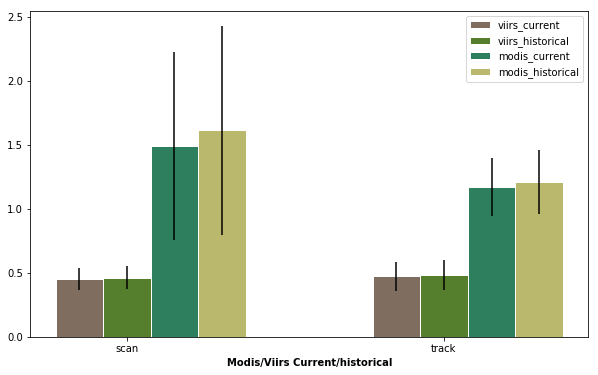

In [30]:
figure(num=1, figsize=(10,6))

# set width of bar
barWidth = 0.15
 
# set height of bar
bars1 = [v.scan.mean(), v.track.mean()]
bars2 = [vh.scan.mean(), vh.track.mean()]
bars3 = [m.scan.mean(), m.track.mean()]
bars4 = [mh.scan.mean(), mh.track.mean()]

#set error bars
error1 = [v.scan.std(), v.track.std()]
error2 = [vh.scan.std(), vh.track.std()]
error3 = [m.scan.std(), m.track.std()]
error4 = [mh.scan.std(), mh.track.std()]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, yerr=error1, color='#7f6d5f', width=barWidth, edgecolor='white', label='viirs_current')
plt.bar(r2, bars2, yerr=error2, color='#557f2d', width=barWidth, edgecolor='white', label='viirs_historical')
plt.bar(r3, bars3, yerr=error3, color='#2d7f5e', width=barWidth, edgecolor='white', label='modis_current')
plt.bar(r4, bars4, yerr=error4, color='#bab86c', width=barWidth, edgecolor='white', label='modis_historical')
 
# Add xticks on the middle of the group bars
plt.xlabel('Modis/Viirs Current/historical', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['scan', 'track'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

The differing values of scan and track likely relate to the different pixel resolution of the modis and viirs instruments. Modis resolves to 1km x 1km ( https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl ) while viirs at .375 km x 375km ( https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/v1-vnp14imgt ). 

To check if the values are absolute measures, we can try normalizing the modus scan and track to .375, which should make these values very similar.

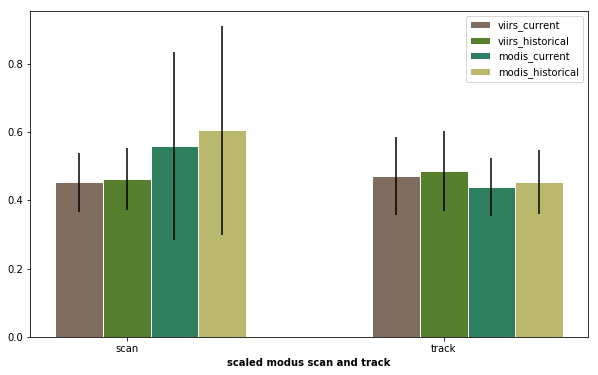

In [29]:
figure(num=1, figsize=(10,6))

# set width of bar
barWidth = 0.15
 
# set height of bar
bars1 = [v.scan.mean(), v.track.mean()]
bars2 = [vh.scan.mean(), vh.track.mean()]
bars3 = [m.scan.apply(lambda x: x*.375).mean(), m.track.apply(lambda x: x*.375).mean()]
bars4 = [mh.scan.apply(lambda x: x*.375).mean(), mh.track.apply(lambda x: x*.375).mean()]

#set error bars
error1 = [v.scan.std(), v.track.std()]
error2 = [vh.scan.std(), vh.track.std()]
error3 = [m.scan.apply(lambda x: x*.375).std(), m.track.apply(lambda x: x*.375).std()]
error4 = [mh.scan.apply(lambda x: x*.375).std(), mh.track.apply(lambda x: x*.375).std()]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, yerr=error1, color='#7f6d5f', width=barWidth, edgecolor='white', label='viirs_current')
plt.bar(r2, bars2, yerr=error2, color='#557f2d', width=barWidth, edgecolor='white', label='viirs_historical')
plt.bar(r3, bars3, yerr=error3, color='#2d7f5e', width=barWidth, edgecolor='white', label='modis_current')
plt.bar(r4, bars4, yerr=error4, color='#bab86c', width=barWidth, edgecolor='white', label='modis_historical')
 
# Add xticks on the middle of the group bars
plt.xlabel('scaled modus scan and track', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['scan', 'track'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

The values look more similar now so we will conclude that our understanding is sufficient and treat these measurements as from the same scale.

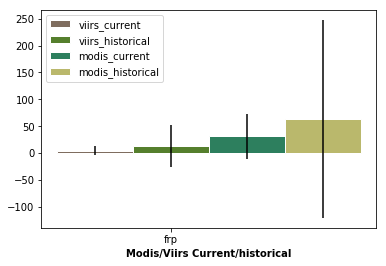

In [31]:
#figure(num=1, figsize=(8,4))

# set width of bar
barWidth = 0.15
 
# set height of bar
bars1 = [v.frp.mean()]
bars2 = [vh.frp.mean()]
bars3 = [m.frp.mean()]
bars4 = [mh.frp.mean()]

#set error bars
error1 = [v.frp.std()]
error2 = [vh.frp.std()]
error3 = [m.frp.std()]
error4 = [mh.frp.std()]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, yerr=error1, color='#7f6d5f', width=barWidth, edgecolor='white', label='viirs_current')
plt.bar(r2, bars2, yerr=error2, color='#557f2d', width=barWidth, edgecolor='white', label='viirs_historical')
plt.bar(r3, bars3, yerr=error3, color='#2d7f5e', width=barWidth, edgecolor='white', label='modis_current')
plt.bar(r4, bars4, yerr=error4, color='#bab86c', width=barWidth, edgecolor='white', label='modis_historical')
 
# Add xticks on the middle of the group bars
plt.xlabel('Modis/Viirs Current/historical', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['frp'])
 
# Create legend & Show graphic
plt.legend(loc='upper left')
plt.show()

FRP is a measure of fire intensity/energy, viirs actually cannot measure medium band fire intensity due to the wavelength that the sensor uses. This biases FRP for viirs downwards.

This feature will have to be managed and perhaps dropped in our simple model

In [45]:
# historical modus and viirs data
mh = pd.read_csv('~/datascience/burn notice/Data-Science/Data/DL_FIRE_M6_66499 - Historical Modis/fire_archive_M6_66499.csv')
vh = pd.read_csv('~/datascience/burn notice/Data-Science/Data/fire_archive_V1_67178.csv')
vh.shape, mh.shape

((3623813, 14), (1780524, 15))

In [46]:
vh.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,type
0,39.21748,-76.47753,328.3,0.59,0.53,2012-01-20,619,N,VIIRS,n,1,272.9,5.5,2
1,39.21451,-76.47873,328.7,0.59,0.53,2012-01-20,619,N,VIIRS,n,1,271.7,5.2,2
2,40.39339,-79.85433,334.5,0.46,0.63,2012-01-20,619,N,VIIRS,n,1,265.8,5.0,2
3,34.37696,-79.88717,307.5,0.41,0.61,2012-01-20,620,N,VIIRS,n,1,273.3,1.0,2
4,34.37386,-79.89035,296.8,0.41,0.61,2012-01-20,620,N,VIIRS,n,1,273.7,1.4,2


In [47]:
mh.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,19.3530,-155.0576,400.1,1.0,1.0,2001-01-01,849,Terra,MODIS,100,6.2,311.8,255.8,N,2
1,19.3378,-155.0360,311.6,1.0,1.0,2001-01-01,849,Terra,MODIS,83,6.2,296.9,9.8,N,2
2,19.3544,-155.0482,322.2,1.0,1.0,2001-01-01,849,Terra,MODIS,100,6.2,293.6,19.6,N,2
3,19.3468,-155.0375,362.5,1.0,1.0,2001-01-01,849,Terra,MODIS,100,6.2,303.1,92.9,N,2
4,19.3516,-155.0670,313.6,1.0,1.0,2001-01-01,849,Terra,MODIS,87,6.2,291.4,11.8,N,2


In [48]:
# unfortunately it seems that the historical viirs ds doesn't have a daynight column when the modern VIIRS datasource does
mv_hist = pd.merge(mh.drop(columns=['confidence', 'daynight', 'type']),vh.drop(columns=['confidence','type']), how='outer').fillna(0)

# drop instrument and rename version to match current data
mv_hist.drop(columns='instrument', inplace=True)

hversion_to_names = {'6.2' : 'modis', '1T' : 'viirs'}
mv_hist['version'] = mv_hist['version'].map(hversion_to_names)

In [49]:
mv_current.head(1)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,version,bright_t31,bright_ti4,bright_ti5
0,32.13,-93.39,305.0,1.0,1.0,2019-09-10,420,T,modis,285.6,0.0,0.0


In [ ]:
# drop frp and daynight from current
mv_hist.drop(columns='frp', inplace=True)
mv_current.drop(columns=['frp', 'daynight'], inplace=True)

In [ ]:
# test to see if our features are the same
cf = set(mv_current.columns.tolist())
hf = set(mv_hist.columns.tolist())

In [ ]:
ques = [cf, hf]
for x in ques:
    print(len(x))